In [1]:
import pandas as pd
import numpy as np
import gc
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import pickle

In [2]:
order_prior = pd.read_csv("data/order_products__prior.csv")
order_train = pd.read_csv('data/order_products__train.csv')
orders      = pd.read_csv("data/orders.csv")

In [3]:
temp = order_prior[["order_id",'reordered']].groupby('order_id').agg('sum')

none_prior=pd.DataFrame({'order_id':temp[temp.reordered==0].index,'product_id':'None','add_to_cart_order':0,'reordered':1})
none_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,6,None,0,1
1,7,None,0,1
2,13,None,0,1
3,20,None,0,1
4,24,None,0,1


In [4]:
temp = order_train[["order_id",'reordered']].groupby('order_id').agg('sum')

none_train=pd.DataFrame({'order_id':temp[temp.reordered==0].index,'product_id':'None','add_to_cart_order':0,'reordered':1})
del temp
none_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,719,None,0,1
1,904,None,0,1
2,1571,None,0,1
3,2711,None,0,1
4,3227,None,0,1


In [5]:
prior_data = pd.concat([order_prior.drop(['add_to_cart_order'],axis=1),none_prior.drop(['add_to_cart_order'],axis=1)])

prior_data.head()

,order_id,product_id,reordered
0,2,33120,1
1,2,28985,1
2,2,9327,0
3,2,45918,1
4,2,30035,0


In [6]:
train_data = pd.concat([order_train.drop(['add_to_cart_order'],axis=1),none_train.drop(['add_to_cart_order'],axis=1)])
train_data.head()

,order_id,product_id,reordered
0,1,49302,1
1,1,11109,1
2,1,10246,0
3,1,49683,0
4,1,43633,1


In [7]:
train_data = train_data.merge(orders,on='order_id',how='left').fillna(0)

In [8]:
del none_prior,none_train,order_prior,order_train
gc.collect()

0

In [9]:
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object, 'category']:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

# Annotate text on graph
def annotate_text(p, append_to_text='%'):
    for p in ax.patches:
        txt = str(p.get_height().round(2)) + append_to_text
        txt_x = p.get_x() + p.get_width()/2.
        txt_y = 0.92*p.get_height()
        ax.text(txt_x,txt_y,txt, fontsize=20, color='#004235', ha='center', va='bottom')

In [10]:
prior_ = prior_data.merge(orders[['user_id','order_id','eval_set']],on='order_id',how='left')
prior_.drop(['order_id','reordered','eval_set'],axis=1,inplace=True)
prior_ = prior_.drop_duplicates()
prior_ = reduce_mem_usage(prior_)
print("Total null values",prior_.isnull().any().sum().sum())
print("The shape of the train_data {}".format(prior_.shape))

Memory usage of dataframe is 309.31 MB
Memory usage after optimization is: 207.60 MB
Decreased by 32.9%
Total null values 0
The shape of the train_data (13514162, 2)


In [11]:
train_feat = prior_.merge(train_data[['user_id','order_id','order_number','order_dow','order_hour_of_day'
                                      ,'days_since_prior_order']]
             ,on='user_id').drop_duplicates()
train_feat = reduce_mem_usage(train_feat)

Memory usage of dataframe is 460.99 MB
Memory usage after optimization is: 206.57 MB
Decreased by 55.2%


In [12]:
del prior_,orders
gc.collect()

0

In [13]:
sys.getsizeof(train_feat)

217992007

In [14]:
train_feat.user_id = train_feat.user_id.astype(np.int32)
train_feat.order_id = train_feat.order_id.astype(np.int32)
train_feat.order_number = train_feat.order_number.astype(np.int8)
train_feat.order_dow = train_feat.order_dow.astype(np.int8)
train_feat.order_hour_of_day = train_feat.order_hour_of_day.astype(np.int8)
train_feat.days_since_prior_order = train_feat.days_since_prior_order.astype(np.int8)

In [15]:
sys.getsizeof(train_feat)

209386137

In [16]:
train_feat = train_feat.merge(train_data[['order_id','product_id','reordered']],on=['order_id','product_id'],how='left')
train_feat.reordered = train_feat.reordered.fillna(0)

In [17]:
train_feat.reordered = train_feat.reordered.astype(np.int8)

In [18]:
sys.getsizeof(train_feat)

493814831

In [19]:
pickle.dump(train_feat,open('train_features_nofeat.pkl','wb'))

## Loading file

In [20]:
train_data = pickle.load(open('train_features_nofeat.pkl','rb'))
print(train_data.shape)
train_data = reduce_mem_usage(train_data)
train_data.head()

(8605870, 8)
Memory usage of dataframe is 238.01 MB
Memory usage after optimization is: 206.57 MB
Decreased by 13.2%


,product_id,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,33120,202279,1050357,9,1,14,30,1
1,28985,202279,1050357,9,1,14,30,0
2,9327,202279,1050357,9,1,14,30,0
3,45918,202279,1050357,9,1,14,30,0
4,30035,202279,1050357,9,1,14,30,0


## Merging features 

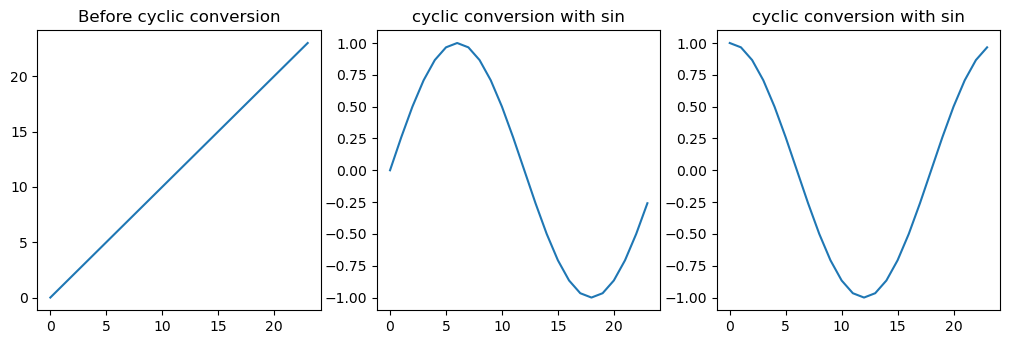

In [21]:
#https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
#https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
#http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
left  = 0.125  # the left side of the subplots of the figure
right = 1.5    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 3    # the amount of height reserved for white space between subplots

plt.figure(figsize=(7,7))
plt.subplot(1,3,1)
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.plot(np.sort(train_data.order_hour_of_day.unique()))
plt.title("Before cyclic conversion")

plt.subplot(1,3,2)
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.plot(np.sin(2*np.pi*np.sort(train_data.order_hour_of_day.unique())/24))
plt.title("cyclic conversion with sin")

plt.subplot(1,3,3)
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.plot(np.cos(2*np.pi*np.sort(train_data.order_hour_of_day.unique())/24))
plt.title("cyclic conversion with sin")
plt.show()

In [22]:
train_data['cos_cyclic_hour'] = np.cos((2*np.pi*train_data.order_hour_of_day)/24).astype(np.float16)
train_data['sin_cyclic_hour'] = np.sin((2*np.pi*train_data.order_hour_of_day)/24).astype(np.float16)
train_data['cos_cyclic_day']  = np.cos((2*np.pi*train_data.order_dow)/7).astype(np.float32)
train_data['sin_cyclic_day']  = np.sin((2*np.pi*train_data.order_dow)/7).astype(np.float32)

In [23]:
day_prior_ratio = pickle.load(open('day_prior_ratio.pkl','rb'))
hour_ratio      = pickle.load(open('hour_of_week.pkl','rb'))
day_week_ratio  = pickle.load(open('day_of_week.pkl','rb'))
user_product    = pickle.load(open('user_product_ratio.pkl','rb'))
product_day_week_ratio  = pickle.load(open('product_day_week_ratio.pkl','rb'))
product_hour_ratio=pickle.load(open('product_hour_ratio.pkl','rb'))
user_day_ratio  = pickle.load(open('user_day_ratio.pkl','rb'))  
user_hour_ratio = pickle.load(open('user_hour_ratio.pkl','rb'))
user_since_product = pickle.load(open('user_since_product.pkl','rb'))
user_times_product = pickle.load(open('user_times_product.pkl','rb'))

In [24]:
train_data = train_data.merge(day_prior_ratio,on='days_since_prior_order')

In [25]:
train_data = train_data.merge(hour_ratio,on='order_hour_of_day')

In [26]:
train_data = train_data.merge(product_hour_ratio,on=['product_id','order_hour_of_day'],how='left')

In [27]:
train_data = train_data.merge(day_week_ratio,on='order_dow')

In [28]:
train_data = train_data.merge(product_day_week_ratio,on=['product_id','order_dow'],how='left')

In [29]:
train_data = train_data.merge(user_product,on=['user_id','product_id'],how='left').fillna(0)

In [30]:
train_data = train_data.merge(user_day_ratio,on=['user_id','order_dow'],how='left')

In [31]:
train_data = train_data.merge(user_hour_ratio,on=['user_id','order_hour_of_day'],how='left')

In [32]:
train_data = train_data.merge(user_since_product,on=['user_id','product_id'],how='left')

In [33]:
train_data = train_data.merge(user_times_product,on=['user_id','product_id'],how='left')

In [34]:
train_data.shape

(8605870, 22)

In [35]:
train_data = train_data.fillna(0)

In [36]:
pro_pro = []
for i in tqdm(range(len(train_data))):
    if train_data.loc[i,'since_order_product']==0:
        pro_pro.append(train_data.loc[i,'days_since_prior_order'])
    else:
        pro_pro.append(train_data.loc[i,'since_order_product'])

100%|█████████████████████████████████████████████████████████████████████| 8605870/8605870 [08:44<00:00, 16398.27it/s]


In [37]:
train_data['pro_pro'] = pro_pro

-> These weighted features are referenced from https://github.com/alexanderrich/instacart-analysis/blob/master/preprocess.py

In [38]:
train_data['weight7days_sin_since_product'] = (1.01 + np.sin(2*np.pi*(train_data['pro_pro']/7)))/2
train_data['weight7days_cos_since_product'] = (1.01 + np.cos(2*np.pi*(train_data['pro_pro']/7)))/2

In [39]:
train_data['weight14days_sin_since_product'] = (1.01 + np.sin(2*np.pi*(train_data['pro_pro']/14)))/2
train_data['weight14days_cos_since_product'] = (1.01 + np.cos(2*np.pi*(train_data['pro_pro']/14)))/2

In [40]:
train_data['weight30days_sin_since_product'] = (1.01 + np.sin(2*np.pi*(train_data['pro_pro']/30)))/2
train_data['weight30days_cos_since_product'] = (1.01 + np.cos(2*np.pi*(train_data['pro_pro']/30)))/2

In [41]:
train_data.isna().sum()

product_id                        0
user_id                           0
order_id                          0
order_number                      0
order_dow                         0
order_hour_of_day                 0
days_since_prior_order            0
reordered                         0
cos_cyclic_hour                   0
sin_cyclic_hour                   0
cos_cyclic_day                    0
sin_cyclic_day                    0
daypriorratio                     0
hod_ratio                         0
product_hour_ratio                0
dow_ratio                         0
product_day_ratio                 0
user_product_ratio                0
user_day_ratio                    0
user_hour_ratio                   0
since_order_product               0
user_times_product                0
pro_pro                           0
weight7days_sin_since_product     0
weight7days_cos_since_product     0
weight14days_sin_since_product    0
weight14days_cos_since_product    0
weight30days_sin_since_produ

In [42]:
train_data.drop('pro_pro',axis=1,inplace=True)

In [43]:
train_data.shape

(8605870, 28)

In [44]:
vectars = pickle.load(open('products_pca.pkl','rb'))

In [45]:
col = ['pca'+str(i) for i in range(0,30)]
vectars[col] = vectars[col].astype(np.float32)

In [46]:
train_data = train_data.merge(vectars,on='product_id')

In [47]:
sys.getsizeof(train_data)

2731341031

In [48]:
pickle.dump(train_data,open('train_features.pkl','wb'))

In [49]:
train_data.columns

Index(['product_id', 'user_id', 'order_id', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'reordered',
       'cos_cyclic_hour', 'sin_cyclic_hour', 'cos_cyclic_day',
       'sin_cyclic_day', 'daypriorratio', 'hod_ratio', 'product_hour_ratio',
       'dow_ratio', 'product_day_ratio', 'user_product_ratio',
       'user_day_ratio', 'user_hour_ratio', 'since_order_product',
       'user_times_product', 'weight7days_sin_since_product',
       'weight7days_cos_since_product', 'weight14days_sin_since_product',
       'weight14days_cos_since_product', 'weight30days_sin_since_product',
       'weight30days_cos_since_product', 'pca0', 'pca1', 'pca2', 'pca3',
       'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca11',
       'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17', 'pca18', 'pca19',
       'pca20', 'pca21', 'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27',
       'pca28', 'pca29'],
      dtype='object')